In [1]:
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from torchtext.data import get_tokenizer
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn
import torch.nn.functional as F
from time import time
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from autocorrect import Speller
from nltk.stem import WordNetLemmatizer
import pycountry
import itertools
import random
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import itertools
import random
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from gensim.models import Word2Vec
from sklearn.pipeline import Pipeline

from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import StratifiedKFold
from skopt.callbacks import VerboseCallback

tokenizer = get_tokenizer("basic_english")
lemmatizer = WordNetLemmatizer()
embedding_dim = 1000
spell=Speller(lang="en", fast=True)


In [2]:
# Define paths
path_to_data = "../challenge_data/"
path_to_training_tweets = os.path.join(path_to_data, "train_tweets")
path_to_eval_tweets = os.path.join(path_to_data, "eval_tweets")
output_path = "evaluation_predictions.csv"

## Load Data

In [3]:
# Load data
def load_data(path, verbose=False):
    li = []
    for filename in os.listdir(path):
        df = pd.read_csv(os.path.join(path, filename))
        li.append(df)
    output = pd.concat(li)
    if verbose:
        print(output.head())
        print(f'The shape of the data is: {output.shape}')
    return output

In [4]:
def concat_tweets(df, MAX_SUBGROUP=150, event_type=True):
    """
    For each group of tweets with the same ID/MatchID/PeriodID/EventType, 
    We create `MAX_SUBGROUP` subgroups of tweets by concatenating them.
    Therefore if `MAX_SUBGROUP` = 1, we have 1 tweet per ID/MatchID/PeriodID/EventType
    If `MAX_SUBGROUP` = +inf, we have all the tweets in different subgroups.
    """

    ### Grouping tweets who have same timestamp by concatenating them
    # Create an array of random integers in {0, ..., MAX_SUBGROUP} of size len(df_train)
    df["random_id"] = np.random.randint(0, MAX_SUBGROUP, len(df))
    if event_type:
        df_bis = df.groupby(['ID', "MatchID", "PeriodID", "EventType", "random_id"])['Tweet'].apply(lambda x: ' '.join(x)).reset_index().drop(columns='random_id')
    else:
        df_bis = df.groupby(['ID', "MatchID", "PeriodID", "random_id"])['Tweet'].apply(lambda x: ' '.join(x)).reset_index().drop(columns='random_id')
    df_bis = df_bis.sample(frac=1).reset_index(drop=True)
    return df_bis

# Preprocessing

In [5]:
# Extend the trigram list with full country names
list_of_countries_trigrams = [
    'AFG', 'RSA', 'ALB', 'ALG', 'GER', 'AND', 'ENG', 'ANG', 'AIA', 'ATG', 'KSA', 'ARG', 'ARM', 'ARU', 'AUS', 'AUT',
    'AZE', 'BAH', 'BHR', 'BAN', 'BRB', 'BEL', 'BLZ', 'BEN', 'BER', 'BHU', 'BLR', 'MYA', 'BOL', 'BIH', 'BOT', 'BRA',
    'BRU', 'BUL', 'BFA', 'BDI', 'CAM', 'CMR', 'CAN', 'CPV', 'CHI', 'CHN', 'CYP', 'COL', 'COM', 'CGO', 'PRK', 'KOR',
    'CRC', 'CIV', 'CRO', 'CUB', 'CUR', 'DEN', 'DJI', 'DMA', 'SCO', 'EGY', 'UAE', 'ECU', 'ERI', 'ESP', 'EST', 'ESW',
    'USA', 'ETH', 'FIJ', 'FIN', 'FRA', 'GAB', 'GAM', 'GEO', 'GHA', 'GIB', 'GRE', 'GRN', 'GUA', 'GUM', 'GUI', 'EQG',
    'GNB', 'GUY', 'HAI', 'HON', 'HKG', 'HUN', 'CAY', 'COK', 'FRO', 'SOL', 'TCA', 'VGB', 'VIR', 'IND', 'IDN', 'IRQ',
    'IRN', 'IRL', 'NIR', 'ISL', 'ISR', 'ITA', 'JAM', 'JPN', 'JOR', 'KAZ', 'KEN', 'KGZ', 'KVX', 'KUW', 'LAO', 'LES',
    'LVA', 'LBN', 'LBR', 'LBY', 'LIE', 'LTU', 'LUX', 'MAC', 'MKD', 'MAD', 'MAS', 'MWI', 'MDV', 'MLI', 'MLT', 'MAR',
    'MRI', 'MTN', 'MEX', 'MDA', 'MNG', 'MNE', 'MSR', 'MOZ', 'NAM', 'NEP', 'NCA', 'NIG', 'NGA', 'NOR', 'NCL', 'NZL',
    'OMA', 'UGA', 'UZB', 'PAK', 'PLE', 'PAN', 'PNG', 'PAR', 'NED', 'WAL', 'PER', 'PHI', 'POL', 'PUR', 'POR', 'QAT',
    'COD', 'CTA', 'DOM', 'CZE', 'ROU', 'RUS', 'RWA', 'SKN', 'SMR', 'VIN', 'LCA', 'SLV', 'SAM', 'ASA', 'STP', 'SEN',
    'SRB', 'SEY', 'SLE', 'SIN', 'SVK', 'SVN', 'SOM', 'SDN', 'SSD', 'SRI', 'SWE', 'SUI', 'SUR', 'SYR', 'TJK', 'TAH',
    'TPE', 'TAN', 'CHA', 'THA', 'TLS', 'TOG', 'TGA', 'TRI', 'TUN', 'TKM', 'TUR', 'UKR', 'URU', 'VAN', 'VEN', 'VIE',
    'YEM', 'ZAM', 'ZIM', 'BOE', 'GUF', 'GBR', 'GLP', 'NMI', 'KIR', 'MTQ', 'NIU', 'REU', 'SMN', 'SMA', 'TUV', 'ZAN',
    'ALA', 'COR', 'GRL', 'GUE', 'IMA', 'FLK', 'MHL', 'JER', 'MYT', 'FSM', 'MCO', 'PLW', 'EUS', 'ESH', 'BLM', 'SPM',
    'SHN', 'VAT', 'WLF'
]

# Add full country names dynamically using pycountry
list_of_countries_full_names = english_countries = ['Afghanistan', 'Albania', 'Algeria', 'Andorra', 'Angola', 'Antigua and Barbuda', 'Argentina', 'Armenia', 'Australia', 'Austria', 'Azerbaijan', 'Bahrain', 'Bangladesh', 'Barbados', 'Belarus', 'Belgium', 'Belize', 'Benin', 'Bhutan', 'Bolivia', 'Bosnia and Herzegovina', 'Botswana', 'Brazil', 'Brunei', 'Bulgaria', 'Burkina Faso', 'Burundi', 'Cambodia', 'Cameroon', 'Canada', 'Cape Verde', 'Central African Republic', 'Chad', 'Chile', 'China', 'Colombia', 'Comoros', 'Congo', 'Congo (Democratic Republic)', 'Costa Rica', 'Croatia', 'Cuba', 'Cyprus', 'Czechia', 'Denmark', 'Djibouti', 'Dominica', 'Dominican Republic', 'East Timor', 'Ecuador', 'Egypt', 'El Salvador', 'Equatorial Guinea', 'Eritrea', 'Estonia', 'Eswatini', 'Ethiopia', 'Fiji', 'Finland', 'France', 'Gabon', 'Georgia', 'Germany', 'Ghana', 'Greece', 'Grenada', 'Guatemala', 'Guinea', 'Guinea-Bissau', 'Guyana', 'Haiti', 'Honduras', 'Hungary', 'Iceland', 'India', 'Indonesia', 'Iran', 'Iraq', 'Ireland', 'Israel', 'Italy', 'Ivory Coast', 'Jamaica', 'Japan', 'Jordan', 'Kazakhstan', 'Kenya', 'Kiribati', 'Kosovo', 'Kuwait', 'Kyrgyzstan', 'Laos', 'Latvia', 'Lebanon', 'Lesotho', 'Liberia', 'Libya', 'Liechtenstein', 'Lithuania', 'Luxembourg', 'Madagascar', 'Malawi', 'Malaysia', 'Maldives', 'Mali', 'Malta', 'Marshall Islands', 'Mauritania', 'Mauritius', 'Mexico', 'Federated States of Micronesia', 'Moldova', 'Monaco', 'Mongolia', 'Montenegro', 'Morocco', 'Mozambique', 'Myanmar (Burma)', 'Namibia', 'Nauru', 'Nepal', 'Netherlands', 'New Zealand', 'Nicaragua', 'Niger', 'Nigeria', 'North Korea', 'North Macedonia', 'Norway', 'Oman', 'Pakistan', 'Palau', 'Panama', 'Papua New Guinea', 'Paraguay', 'Peru', 'Philippines', 'Poland', 'Portugal', 'Qatar', 'Romania', 'Russia', 'Rwanda', 'St Kitts and Nevis', 'St Lucia', 'St Vincent', 'Samoa', 'San Marino', 'Sao Tome and Principe', 'Saudi Arabia', 'Senegal', 'Serbia', 'Seychelles', 'Sierra Leone', 'Singapore', 'Slovakia', 'Slovenia', 'Solomon Islands', 'Somalia', 'South Africa', 'South Korea', 'South Sudan', 'Spain', 'Sri Lanka', 'Sudan', 'Suriname', 'Sweden', 'Switzerland', 'Syria', 'Tajikistan', 'Tanzania', 'Thailand', 'The Bahamas', 'The Gambia', 'Togo', 'Tonga', 'Trinidad and Tobago', 'Tunisia', 'Turkey', 'Turkmenistan', 'Tuvalu', 'Uganda', 'Ukraine', 'United Arab Emirates', 'United Kingdom', 'United States', 'Uruguay', 'Uzbekistan', 'Vanuatu', 'Vatican City', 'Venezuela', 'Vietnam', 'Yemen', 'Zambia', 'Zimbabwe']


# Combine trigrams and full names into one list
list_of_countries_trigrams.extend(list_of_countries_full_names)
list_of_countries_trigrams = list(set(list_of_countries_trigrams))  # Remove duplicates

# Preload stopwords (ensure NLTK stopwords are downloaded)
stop_words = set(stopwords.words("english"))

stemmer = SnowballStemmer("english")
country_pattern = re.compile(r"\b(" + "|".join(map(re.escape, list_of_countries_trigrams)) + r")\b", re.IGNORECASE)
WORD = re.compile(r'\w+')
def reTokenize(doc):
    tokens = WORD.findall(doc)
    return tokens

def preprocessing(df):
    # Compile regex patterns for efficiency
    url_pattern = re.compile(r"http[s]?://\S+|www\.\S+")
    mention_pattern = re.compile(r"@\w+")
    hashtag_pattern = re.compile(r"#\w+")
    number_pattern = re.compile(r"\d+")
    punctuation_pattern = re.compile(r"[^\w\s]")
    country_pattern = re.compile(r"\b(" + "|".join(map(re.escape, list_of_countries_trigrams)) + r")\b", re.IGNORECASE)
    rt_pattern = re.compile(r"rt")

    def clean_tweet(tweet):
        tweet = tweet.lower()  # Lowercase the text
        tweet = url_pattern.sub("", tweet)  # Remove URLs
        tweet = rt_pattern.sub("", tweet)  # Remove RT
        tweet = mention_pattern.sub("", tweet)  # Replace mentions with 'user'
        tweet = hashtag_pattern.sub("", tweet)  # Replace hashtags with 'hashtag'
        tweet = number_pattern.sub("", tweet)  # Replace numbers with 'number'
        tweet = country_pattern.sub("", tweet)  # Replace country trigrams with 'country'
        tweet = punctuation_pattern.sub("", tweet)  # Remove punctuation
        # tweet = " ".join([word for word in tweet.split() if word not in stop_words])  # Remove stopwords
        words = tweet.split()
        words = [stemmer.stem(word) for word in words if word not in stop_words]  # Remove stopwords and apply stemming
        tweet = " ".join(words)
        tweet = ' '.join([spell(w) for w in reTokenize(tweet)]) 
        return tweet

    # Apply cleaning to the "Tweet" column
    df["Tweet"] = df["Tweet"].apply(clean_tweet)
    return df

## Create dictionary from tweets

In [6]:
def create_vocab(df, column_name, tokenizer, embedding_dim):
    words = []
    for text in df[column_name]:
        words.extend(tokenizer(text))
    vocab = dict(Counter(words).most_common(embedding_dim))
    return vocab, list(vocab.keys())

In [7]:
def plot_frequency(vocab, keywords, max_words = 40):
    top_keywords = keywords[:max_words]
    top_counts = [vocab[word] for word in top_keywords]

    plt.figure(figsize=(10, 5))
    plt.bar(top_keywords, top_counts)
    plt.xlabel('Keywords')
    plt.ylabel('Frequency')
    plt.title('Top 20 Keywords Frequency')
    plt.xticks(rotation=45)
    plt.show()

# Embedding

In [8]:
def embedding(tweets, keywords=["football", "goal"]):
    feature_matrix = []
    for i, text in enumerate(tweets):
        tokens = tokenizer(text) # ex : 'Hello, I am a test' -> ['hello', 'i', 'am', 'a', 'test']
        token_counts = Counter(tokens)
        len_token = max(len(tokens), 1)
        frequencies = [token_counts.get(keyword, 0)/len_token for keyword in keywords]
        feature_matrix.append(frequencies)
    feature_matrix = np.array(feature_matrix)
    return feature_matrix 

def fit_tfidf_embedding(train_tweets, max_features=2000, ngram_range=(1,1), max_df=0.7, min_df=2, sublinear_tf=False):
    """
    Fit a TF-IDF vectorizer on the training tweets.
    Returns the fitted vectorizer.
    """
    vectorizer = TfidfVectorizer(max_features=max_features,
                                 max_df=max_df,
                                 ngram_range=ngram_range,
                                 min_df=min_df,
                                 sublinear_tf=sublinear_tf)
    vectorizer.fit(train_tweets)
    return vectorizer

def tfidf_embedding(tweets, vectorizer):
    """
    Transform tweets into TF-IDF features using a fitted vectorizer.
    """
    return vectorizer.transform(tweets).toarray()

# Training

In [9]:
def create_sets(train, test, train_X, test_X, batch_size = 64):
    # Scale the data
    scaler = StandardScaler()
    scaler.fit(train_X)
    train_X = scaler.transform(train_X)
    test_X = scaler.transform(test_X)

    # Labels
    train_y = np.array(train['EventType']).reshape(-1, 1).flatten()
    test_y = np.array(test['EventType']).reshape(-1, 1).flatten()
    train_y = torch.tensor(train_y, dtype=torch.float32).view(-1, 1)
    test_y = torch.tensor(test_y, dtype=torch.float32).view(-1, 1)

    trainset = TensorDataset(torch.tensor(train_X, dtype=torch.float32), train_y)
    testset = TensorDataset(torch.tensor(test_X, dtype=torch.float32), test_y)

    train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(testset, batch_size=batch_size, shuffle=False)

    return train_loader, test_loader, scaler

def create_sets_for_eval(eval_X, scaler, batch_size = 64):
    # Scale the data
    eval_X = scaler.transform(eval_X)

    evalset = TensorDataset(torch.tensor(eval_X, dtype=torch.float32))

    eval_loader = DataLoader(evalset, batch_size=batch_size, shuffle=False)

    return eval_loader

In [10]:
class NNModel(nn.Module):
    def __init__(self, input_dim, hidden_dims, output_dim, dropouts):
        super().__init__()
        assert len(hidden_dims) == len(dropouts)
        self.layers = nn.ModuleList()
        in_dim = input_dim
        for hidden_dim, dropout in zip(hidden_dims, dropouts):
            self.layers.append(nn.Linear(in_dim, hidden_dim))
            self.layers.append(nn.ReLU())
            self.layers.append(nn.BatchNorm1d(hidden_dim))
            self.layers.append(nn.Dropout(dropout))
            in_dim = hidden_dim
        self.output_layer = nn.Linear(in_dim, output_dim)
    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        x = self.output_layer(x)
        return torch.sigmoid(x)


In [11]:
def train_model(model, train_loader, test_loader, optimizer, criterion, device, num_epochs=10, scheduler=None, weight_1_0=0.5):
    history = {'train_loss': [], 'val_loss': [], 'val_accuracy': []}
    for epoch in range(num_epochs):
        # Scheduler
        if scheduler:
            scheduler.step()
        # Training
        model.train()
        train_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        # Validation
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                val_loss += criterion(outputs, labels).item()
                predicted = (outputs > weight_1_0).float()
                correct += (predicted == labels).sum().item()
                total += labels.size(0)
        val_accuracy = correct / total
        history['train_loss'].append(train_loss / len(train_loader))
        history['val_loss'].append(val_loss / len(test_loader))
        history['val_accuracy'].append(val_accuracy)

        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss/len(train_loader):.4f}, "
              f"Val Loss: {val_loss/len(test_loader):.4f}, Val Accuracy: {val_accuracy:.4f}")

    return history

In [12]:
def plot_history(history):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Val Loss')
    plt.legend()
    plt.title('Loss')

    plt.subplot(1, 2, 2)
    plt.plot(history['val_accuracy'], label='Val Accuracy')
    plt.legend()
    plt.title('Accuracy')
    plt.show()

# Overfitting of the dictionary

In [7]:
def intersection_keywords(keywords1, keywords2):
    return list(set(keywords1) & set(keywords2))

def proximity_keywords(keywords1, keywords2):
    return len(intersection_keywords(keywords1, keywords2))/max(len(keywords1), len(keywords2))

# Cross-validation and GridSearch on SVM

In [ ]:
Group_train = 10
Group_eval = Group_train

df_train = pd.read_csv("df_train_withoutstemming.csv")
df_eval = pd.read_csv("df_eval_withoutstemming.csv")

df_train['Tweet'] = df_train['Tweet'].astype(str)
df_eval['Tweet'] = df_eval['Tweet'].astype(str)

# Grouping
print("Grouping tweets...")
t = time()

df_train_bis = concat_tweets(df_train, MAX_SUBGROUP=Group_train, event_type=True)
df_eval_bis = concat_tweets(df_eval, MAX_SUBGROUP=Group_eval, event_type=False)

print(f"Tweets grouped in {time()-t:.2f} seconds")
print("-"*50+"\n")

# Splitting
print("Splitting data...")
t = time()

train, test = train_test_split(df_train_bis, test_size=0.01, random_state=42)

print(f"Data splitted in {time()-t:.2f} seconds")
print("-"*50+"\n")

# Embedding
print("Embedding...")
t = time()

# Fit on training data
vectorizer = fit_tfidf_embedding(train['Tweet'], max_features=embedding_dim)

# Transform data
train_X = tfidf_embedding(train['Tweet'], vectorizer)
test_X = tfidf_embedding(test['Tweet'], vectorizer)
eval_X = tfidf_embedding(df_eval['Tweet'], vectorizer)

print(f"Data embedded in {time()-t:.2f} seconds")
print("-"*50+"\n")

# Creating the datasets
print("Creating the datasets...")
t = time()

train_loader, test_loader, scaler = create_sets(train, test, train_X, test_X)

print(f"Datasets created in {time()-t:.2f} seconds")
print("-"*50+"\n")


Grouping tweets...
Tweets grouped in 2.17 seconds
--------------------------------------------------

Splitting data...
Data splitted in 0.00 seconds
--------------------------------------------------

Embedding...
Data embedded in 32.87 seconds
--------------------------------------------------

Creating the datasets...
Datasets created in 0.29 seconds
--------------------------------------------------



In [34]:
df_train = pd.read_csv("df_train_withoutstemming.csv").head(400000)
df_eval = pd.read_csv("df_eval_withoutstemming.csv").head(400000)
df_train['Tweet'] = df_train['Tweet'].astype(str)
df_eval['Tweet'] = df_eval['Tweet'].astype(str)

target = 'EventType'
embedding_dim = 2000

group_train_candidates = [10] 
best_overall_score = -np.inf
best_overall_params = None
best_overall_group = None
best_overall_svm = None

# SVM parameter search space
search_spaces = {
    'C': Real(1e-3, 1e2, prior='log-uniform'),
    'kernel': Categorical(['linear', 'rbf', 'poly']),
    'gamma': Categorical(['scale', 'auto'])
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

def on_step(res):
    iteration = len(res.x_iters)
    params = res.x_iters[-1]
    score = res.func_vals[-1]
    print(f"Iteration {iteration}: Testing params={params} => CV Score: {score:.4f}")

for g in group_train_candidates:
    print(f"Processing group_train={g}...")
    t0 = time()
    # Group and embed once
    df_train_grouped = concat_tweets(df_train, MAX_SUBGROUP=g, event_type=True)
    vectorizer = fit_tfidf_embedding(df_train_grouped['Tweet'], max_features=embedding_dim)
    X_train = tfidf_embedding(df_train_grouped['Tweet'], vectorizer)
    y_train = df_train_grouped[target].values
    print(f"Data grouped and embedded for group_train={g} in {time()-t0:.2f}s")
    print("X_train shape:", X_train.shape, "y_train length:", len(y_train))

    svm_clf = SVC()
    bayes_search = BayesSearchCV(
        estimator=svm_clf,
        search_spaces=search_spaces,
        n_iter=15,
        scoring='accuracy',
        cv=cv,
        n_jobs=-1,
        verbose=0,
        random_state=42
    )

    print("Running BayesSearchCV...")
    bayes_search.fit(X_train, y_train, callback=[VerboseCallback(n_total=5), on_step])
    print(f"Best parameters found for group_train={g}:", bayes_search.best_params_)
    print(f"Best CV accuracy for group_train={g}:", bayes_search.best_score_)

    if bayes_search.best_score_ > best_overall_score:
        best_overall_score = bayes_search.best_score_
        best_overall_params = bayes_search.best_params_
        best_overall_group = g
        best_overall_svm = bayes_search.best_estimator_

print("\n\nOverall best results:")
print(f"Best group_train: {best_overall_group}")
print("Best SVM parameters:", best_overall_params)
print("Best overall CV accuracy:", best_overall_score)

# Once you've found the best group_train and SVM parameters,
# you can retrain with these on the entire training set (already done above)
# and apply the same logic to eval set.
df_eval_grouped = concat_tweets(df_eval, MAX_SUBGROUP=best_overall_group, event_type=False)
X_eval = tfidf_embedding(df_eval_grouped['Tweet'], vectorizer)
eval_pred = best_overall_svm.predict(X_eval)

Processing group_train=10...
Data grouped and embedded for group_train=10 in 2.30s
X_train shape: (2990, 2000) y_train length: 2990
Running BayesSearchCV...
Iteration No: 1 started. Searching for the next optimal point.
Iteration No: 1 ended. Search finished for the next optimal point.
Time taken: 21.9144
Function value obtained: -0.5351
Current minimum: -0.5351
Iteration No: 2 started. Searching for the next optimal point.
Iteration 1: Testing params=[0.11233621690895233, 'auto', 'poly'] => CV Score: -0.5351
Iteration No: 2 ended. Search finished for the next optimal point.
Time taken: 8.6453
Function value obtained: -0.8559
Current minimum: -0.8559
Iteration No: 3 started. Searching for the next optimal point.
Iteration 2: Testing params=[15.37948446580078, 'auto', 'linear'] => CV Score: -0.8559
Iteration No: 3 ended. Search finished for the next optimal point.
Time taken: 13.6690
Function value obtained: -0.8244
Current minimum: -0.8559
Iteration No: 4 started. Searching for the nex

# Evaluating the best SVM 

In [14]:
best_overall_group = 10

# Load data 
t = time()
print("Loading data...")

df_train = pd.read_csv("df_train_withoutstemming.csv")
df_eval = pd.read_csv("df_eval_withoutstemming.csv")

df_train['Tweet'] = df_train['Tweet'].astype(str)
df_eval['Tweet'] = df_eval['Tweet'].astype(str)
print(f"Data loaded in {time()-t:.2f} seconds")

# Grouping
print("Grouping tweets...")
t = time()

df_train_bis = concat_tweets(df_train, MAX_SUBGROUP=best_overall_group, event_type=True)
df_eval_bis = concat_tweets(df_eval, MAX_SUBGROUP=best_overall_group, event_type=False)

print(f"Tweets grouped in {time()-t:.2f} seconds")
print("-"*50+"\n")

# Splitting
print("Splitting data...")
t = time()

train, test = train_test_split(df_train_bis, test_size=0.01, random_state=42)

print(f"Data splitted in {time()-t:.2f} seconds")
print("-"*50+"\n")

# Embedding
print("Embedding...")
t = time()

# Fit on training data
vectorizer = fit_tfidf_embedding(train['Tweet'], max_features=embedding_dim)

# Transform data
train_X = tfidf_embedding(train['Tweet'], vectorizer)
test_X = tfidf_embedding(test['Tweet'], vectorizer)
eval_X = tfidf_embedding(df_eval['Tweet'], vectorizer)

print(f"Data embedded in {time()-t:.2f} seconds")
print("-"*50+"\n")

# Creating the datasets
print("Creating the datasets...")
t = time()

train_loader, test_loader, scaler = create_sets(train, test, train_X, test_X)

print(f"Datasets created in {time()-t:.2f} seconds")
print("-"*50+"\n")


Loading data...
Data loaded in 3.24 seconds
Grouping tweets...
Tweets grouped in 1.63 seconds
--------------------------------------------------

Splitting data...
Data splitted in 0.00 seconds
--------------------------------------------------

Embedding...
Data embedded in 27.01 seconds
--------------------------------------------------

Creating the datasets...
Datasets created in 0.21 seconds
--------------------------------------------------



In [16]:
# Regularized SVM
print("Testing on SVM with regularization:")
t = time()
svm = SVC(C=0.1, 
          kernel='rbf',
          gamma='scale')
svm.fit(train_X, train['EventType'])
print("SVM Accuracy:", svm.score(test_X, test['EventType']))
print(f"Model trained in {time()-t:.2f} seconds")

Testing on SVM with regularization:
SVM Accuracy: 0.7570093457943925
Model trained in 180.32 seconds


In [37]:
# Regularized SVM
print("Testing on SVM with regularization:")
t = time()
svm2 = SVC(C=0.1, 
          kernel='rbf',
          gamma='auto')
svm2.fit(train_X, train['EventType'])
print("SVM Accuracy:", svm2.score(test_X, test['EventType']))
print(f"Model trained in {time()-t:.2f} seconds")

Testing on SVM with regularization:
SVM Accuracy: 0.5700934579439252
Model trained in 531.11 seconds


In [ ]:
# Regularized SVM
print("Testing on SVM with regularization:")
t = time()
svm3 = SVC(C=0.1, 
          kernel='sigmoid',
          gamma='scale')
svm3.fit(train_X, train['EventType'])
print("SVM Accuracy:", svm3.score(test_X, test['EventType']))
print(f"Model trained in {time()-t:.2f} seconds")

Testing on SVM with regularization:
SVM Accuracy: 0.7663551401869159
Model trained in 421.52 seconds


In [15]:
# Regularized SVM
print("Testing on SVM with regularization:")
t = time()
svm3 = SVC(C=0.1, 
          kernel='linear',
          gamma='scale')
svm3.fit(train_X, train['EventType'])
print("SVM Accuracy:", svm3.score(test_X, test['EventType']))
print(f"Model trained in {time()-t:.2f} seconds")

Testing on SVM with regularization:
SVM Accuracy: 0.7383177570093458
Model trained in 176.10 seconds


In [17]:
for coef in [0.0, 0.1, 0.5, 1.0]:
    # Regularized SVM
    print(f"Testing on SVM with regularization coef={coef}:")
    t = time()
    svm3 = SVC(C=0.1, 
            kernel='sigmoid',
            gamma='scale',
            coef0=coef)
    svm3.fit(train_X, train['EventType'])
    print("SVM Accuracy:", svm3.score(test_X, test['EventType']))
    print(f"Model trained in {time()-t:.2f} seconds")

Testing on SVM with regularization coef=0.0:
SVM Accuracy: 0.7289719626168224
Model trained in 187.66 seconds
Testing on SVM with regularization coef=0.1:
SVM Accuracy: 0.719626168224299
Model trained in 190.87 seconds
Testing on SVM with regularization coef=0.5:
SVM Accuracy: 0.7009345794392523
Model trained in 197.93 seconds
Testing on SVM with regularization coef=1.0:
SVM Accuracy: 0.7102803738317757
Model trained in 206.80 seconds


In [18]:
for coef in [0.0, 0.1, 0.5, 1.0]:
    # Regularized SVM
    print(f"Testing on SVM with regularization coef={coef}:")
    t = time()
    svm3 = SVC(C=0.1, 
            kernel='linear',
            gamma='scale',
            coef0=coef)
    svm3.fit(train_X, train['EventType'])
    print("SVM Accuracy:", svm3.score(test_X, test['EventType']))
    print(f"Model trained in {time()-t:.2f} seconds")

Testing on SVM with regularization coef=0.0:
SVM Accuracy: 0.7383177570093458
Model trained in 172.17 seconds
Testing on SVM with regularization coef=0.1:
SVM Accuracy: 0.7383177570093458
Model trained in 172.44 seconds
Testing on SVM with regularization coef=0.5:
SVM Accuracy: 0.7383177570093458
Model trained in 172.68 seconds
Testing on SVM with regularization coef=1.0:
SVM Accuracy: 0.7383177570093458
Model trained in 172.21 seconds


In [ ]:
from time import time

t = time()
tweet = "this tweet is in english"
print(detect(tweet))
print(f"Language detected in {time()-t:.6f} seconds")

en
Language detected in 0.003720 seconds
('en', -76.98550987243652)
Language detected in 0.009630 seconds


In [19]:

# Regularized SVM
print(f"Testing on SVM with regularization :")
t = time()
svm3 = SVC(C=0.1, 
        kernel='linear',
        gamma='scale',
        class_weight='balanced')
svm3.fit(train_X, train['EventType'])
print("SVM Accuracy:", svm3.score(test_X, test['EventType']))
print(f"Model trained in {time()-t:.2f} seconds")

Testing on SVM with regularization :
SVM Accuracy: 0.7523364485981309
Model trained in 189.85 seconds


In [20]:
# Regularized SVM
print("Testing on SVM with regularization:")
t = time()
svm = SVC(C=0.1, 
          kernel='rbf',
          gamma='scale',
            class_weight='balanced')
svm.fit(train_X, train['EventType'])
print("SVM Accuracy:", svm.score(test_X, test['EventType']))
print(f"Model trained in {time()-t:.2f} seconds")

Testing on SVM with regularization:
SVM Accuracy: 0.7523364485981309
Model trained in 214.82 seconds


In [21]:
# Regularized SVM
print("Testing on SVM with regularization:")
t = time()
svm = SVC(C=0.01, 
          kernel='linear',
          gamma='scale',
            class_weight='balanced')
svm.fit(train_X, train['EventType'])
print("SVM Accuracy:", svm.score(test_X, test['EventType']))
print(f"Model trained in {time()-t:.2f} seconds")

Testing on SVM with regularization:
SVM Accuracy: 0.6869158878504673
Model trained in 230.48 seconds


In [22]:
# Regularized SVM
print("Testing on SVM with regularization:")
t = time()
svm = SVC(C=0.01, 
          kernel='rbf',
          gamma='scale',
            class_weight='balanced')
svm.fit(train_X, train['EventType'])
print("SVM Accuracy:", svm.score(test_X, test['EventType']))
print(f"Model trained in {time()-t:.2f} seconds")

Testing on SVM with regularization:
SVM Accuracy: 0.7009345794392523
Model trained in 262.83 seconds


In [23]:
# Regularized SVM
print("Testing on SVM with regularization:")
t = time()
svm = SVC(C=1, 
          kernel='rbf',
          gamma='scale',
            class_weight='balanced')
svm.fit(train_X, train['EventType'])
print("SVM Accuracy:", svm.score(test_X, test['EventType']))
print(f"Model trained in {time()-t:.2f} seconds")

Testing on SVM with regularization:
SVM Accuracy: 0.8364485981308412
Model trained in 249.43 seconds


In [24]:
# Regularized SVM
print("Testing on SVM with regularization:")
t = time()
svm = SVC(C=1, 
          kernel='linear',
          gamma='scale',
            class_weight='balanced')
svm.fit(train_X, train['EventType'])
print("SVM Accuracy:", svm.score(test_X, test['EventType']))
print(f"Model trained in {time()-t:.2f} seconds")

Testing on SVM with regularization:
SVM Accuracy: 0.7523364485981309
Model trained in 174.10 seconds


In [25]:
# Regularized SVM
print("Testing on SVM with regularization:")
t = time()
svm = SVC(C=10, 
          kernel='rbf',
          gamma='scale',
            class_weight='balanced')
svm.fit(train_X, train['EventType'])
print("SVM Accuracy:", svm.score(test_X, test['EventType']))
print(f"Model trained in {time()-t:.2f} seconds")

Testing on SVM with regularization:
SVM Accuracy: 0.8738317757009346
Model trained in 683.18 seconds


In [26]:
# Regularized SVM
print("Testing on SVM with regularization:")
t = time()
svm = SVC(C=10, 
          kernel='linear',
          gamma='scale',
            class_weight='balanced')
svm.fit(train_X, train['EventType'])
print("SVM Accuracy:", svm.score(test_X, test['EventType']))
print(f"Model trained in {time()-t:.2f} seconds")

Testing on SVM with regularization:
SVM Accuracy: 0.7850467289719626
Model trained in 229.00 seconds


In [31]:
best_overall_group = 10
embedding_dim = 1000

# Load data 
t = time()
print("Loading data...")

df_train = pd.read_csv("df_train_withoutstemming.csv")
df_eval = pd.read_csv("df_eval_withoutstemming.csv")

df_train['Tweet'] = df_train['Tweet'].astype(str)
df_eval['Tweet'] = df_eval['Tweet'].astype(str)
print(f"Data loaded in {time()-t:.2f} seconds")

# Grouping
print("Grouping tweets...")
t = time()

df_train_bis = concat_tweets(df_train, MAX_SUBGROUP=best_overall_group, event_type=True)
df_eval_bis = concat_tweets(df_eval, MAX_SUBGROUP=best_overall_group, event_type=False)

print(f"Tweets grouped in {time()-t:.2f} seconds")
print("-"*50+"\n")

# Splitting
print("Splitting data...")
t = time()

train, test = train_test_split(df_train_bis, test_size=0.01, random_state=42)

print(f"Data splitted in {time()-t:.2f} seconds")
print("-"*50+"\n")

# Embedding
print("Embedding...")
t = time()

# Fit on training data
vectorizer = fit_tfidf_embedding(train['Tweet'], max_features=embedding_dim)

# Transform data
train_X = tfidf_embedding(train['Tweet'], vectorizer)
test_X = tfidf_embedding(test['Tweet'], vectorizer)
eval_X = tfidf_embedding(df_eval_bis['Tweet'], vectorizer)

print(f"Data embedded in {time()-t:.2f} seconds")
print("-"*50+"\n")

# Creating the datasets
print("Creating the datasets...")
t = time()

train_loader, test_loader, scaler = create_sets(train, test, train_X, test_X)

print(f"Datasets created in {time()-t:.2f} seconds")
print("-"*50+"\n")


Loading data...
Data loaded in 3.19 seconds
Grouping tweets...
Tweets grouped in 1.50 seconds
--------------------------------------------------

Splitting data...
Data splitted in 0.00 seconds
--------------------------------------------------

Embedding...
Data embedded in 22.96 seconds
--------------------------------------------------

Creating the datasets...
Datasets created in 0.16 seconds
--------------------------------------------------



In [32]:
# Regularized SVM
print("Testing on SVM with regularization:")
t = time()
svm = SVC(C=0.1, 
          kernel='rbf')
svm.fit(train_X, train['EventType'])
print("SVM Accuracy:", svm.score(test_X, test['EventType']))
print(f"Model trained in {time()-t:.2f} seconds")

Testing on SVM with regularization:
SVM Accuracy: 0.7523364485981309
Model trained in 178.91 seconds


In [33]:
pridictions_svm = svm.predict(eval_X)

# Now predictions should align with match3 rows
predictions_eval = pd.DataFrame({
    'ID': df_eval_bis['ID'],
    'MatchID': df_eval_bis['MatchID'],
    'PeriodID': df_eval_bis['PeriodID'],
    'Predicted_SVM': pridictions_svm,
})

# Group by ID/PeriodID/MatchID and average the predictions and sort by matchID and then PeriodID
predictions_eval = predictions_eval.groupby(['ID', 'MatchID', 'PeriodID']).mean().reset_index().sort_values(['MatchID', 'PeriodID'])
predictions_eval['Predicted_SVM_three'] = (predictions_eval['Predicted_SVM'] > 0.5).astype(int)



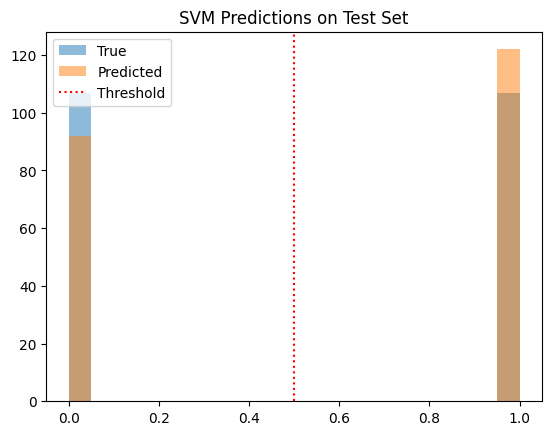

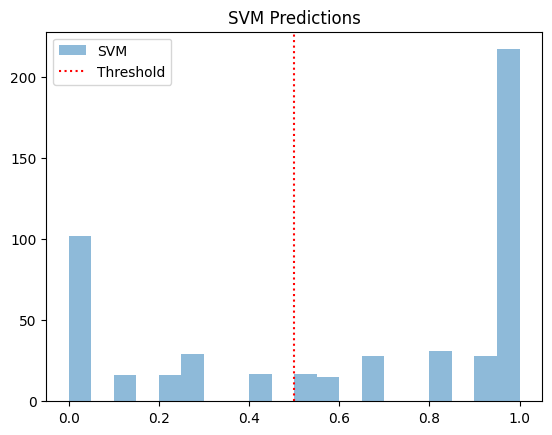

In [34]:
predict_test = svm.predict(test_X)

# Plot histogram of test predictions/true labels
plt.hist(test['EventType'], bins=20, alpha=0.5, label='True')
plt.hist(predict_test, bins=20, alpha=0.5, label='Predicted')
plt.axvline(0.5, color='r', linestyle='dotted', label='Threshold')
plt.legend()
plt.title(f'SVM Predictions on Test Set')

plt.show()

# Plot histogram of predictions
plt.hist(predictions_eval['Predicted_SVM'], bins=20, alpha=0.5, label='SVM')
plt.axvline(0.5, color='r', linestyle='dotted', label='Threshold')
plt.legend()
plt.title(f'SVM Predictions')
plt.show()

In [35]:
# Save in csv file
predictions_eval.drop(columns=['PeriodID', 'Predicted_SVM', 'MatchID']).to_csv('predictions_opt_svm.csv', index=False)
